In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
data = pd.read_csv("train_mnist.csv")
data = data.loc[(data['label']==3) | (data['label']==8)]
dic = {3:-1,8:1}
data['label'] = data['label'].map(dic)
outp, inp = np.array(data.iloc[:,:1]), np.array(data.iloc[:,1:])

lda = LinearDiscriminantAnalysis(n_components=1)
inp = lda.fit(inp, outp).transform(inp)


Xtn, Xtt, Xval = inp[:int(0.6*inp.shape[0]),:], inp[int(0.6*inp.shape[0]):int(0.8*inp.shape[0]),:], inp[int(0.8*inp.shape[0]):,:]
Ytn, Ytt, Yval = outp[:int(0.6*outp.shape[0])], outp[int(0.6*outp.shape[0]):int(0.8*outp.shape[0])], outp[int(0.8*outp.shape[0]):]
data.shape,inp.shape,outp.shape,Xtn.shape,Xtt.shape,Xval.shape,Ytn.shape,Ytt.shape,Yval.shape

C:\Users\Narahc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Narahc\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


((8414, 785),
 (8414, 1),
 (8414, 1),
 (5048, 1),
 (1683, 1),
 (1683, 1),
 (5048, 1),
 (1683, 1),
 (1683, 1))

In [3]:
def kernel(x, y, typ):
    if typ == "rbf":
        sig = 1
        return np.exp(-np.linalg.norm(x - y)**2/(2 * sig**2))
    
    if typ == "quadratic":
        return (np.dot(x, y.T) ** 2)
    
    if typ == "linear":
        return np.dot(x, y)

In [4]:
def predict_accuracy(X, Y, T):
    predictions = W.T.dot(X.T) + B
    predictions = predictions.flatten()
    accuracy = 0
    for i in range(predictions.shape[0]):
        if(predictions[i]>T):
            predictions[i] = 1
        else:
            predictions[i] = -1
        if predictions[i] == Y[i]:
            accuracy += 1
    return predictions,accuracy/Y.shape[0]

In [5]:
max_skips = 5
tolerence = 0.00001

C = 1
accu_vals = []
c_ranges = []
tol_ranges = []
steps = []
# for tol in range(1,100,5):
#     tolerence = 0.01/(tol*10)
# for c in range(0,100,5):
#     C = c/100.0
if True:
    n_samples, dimensions = Xtn.shape[0], Xtn.shape[1] 
    alp = np.zeros([n_samples,1])
    W = np.zeros([dimensions,1])
    B = 0
    skips =0
    kernal_type = "quadratic"
    while skips < max_skips:
    #     print(skips)
        changed = False
        skips = skips + 1
        prev_alp = np.copy(alp)
        for i in range(n_samples):
            xi, yi = Xtn[i,:], Ytn[i]
            Ei = np.sign((W.T.dot(xi.T)) + B) - yi
            if True:
    #         if ((yi*Ei) < -tolerence and alp[i] < C) or ((yi*Ei) > tolerence and alp[i] > C): 
                random_numbers = random.sample(range(0,n_samples), 2)
                j = random_numbers[0]
                if i==j:
                    j = random_numbers[1]

                xj, yj = Xtn[j,:], Ytn[j]


                Ej = np.sign(W.T.dot(xj.T) + B) - yj
                old_ai, old_aj =  alp[i], alp[j]

                if(yi != yj):
                    L = max(0, alp[j] - alp[i])
                    H = min(C, C + alp[j] - alp[i])
                else:
                    L = max(0, alp[j] + alp[i] -C)
                    H = min(C, alp[j] + alp[i])
                if L==H:
                    continue

                n_val = 2 * kernel(xi, xj,kernal_type) - kernel(xi, xi,kernal_type) - kernel(xj, xj, kernal_type)
                
                
                if n_val==0:
                    continue
                alp[j] = alp[j] - float(yj*(Ei-Ej))/n_val

                alp[j] = max(L, min(H, alp[j]))

                alp[i] = alp[i] + yi * yj * (old_aj - alp[j])

                W =  Xtn.T.dot(alp*Ytn)
                b1 = B - Ei - yi*(alp[i] - old_ai)*(xi.dot(xi.T)) - yj * (alp[j] - old_aj)*(xi.dot(xj.T))
                b2 = B - Ej - yi*(alp[i] - old_ai)*(xi.dot(xj.T)) - yj * (alp[j] - old_aj)*(xj.dot(xj.T))

                if old_ai > 0 and old_ai < C and (old_aj <= 0 or old_aj >= C):
                    bt = b1
                elif old_aj > 0 and old_aj < C and (old_ai <= 0 or old_ai >= C):
                    bt = b2
                else:
                    bt = (b1 + b2)/2
                    
#                 bt = Ytn - np.dot(W.T, Xtn.T)
#                 B = np.mean(bt)
        err = np.linalg.norm(alp - prev_alp)
        steps.append(skips)
        predictions, accuracy = predict_accuracy(Xval, Yval, 0)
#         accu_vals.append(accuracy)
#         print("error :",err)
        if  err < tolerence:
            break
    predictions, accuracy = predict_accuracy(Xval, Yval, 0)
    print(accuracy)
    c_ranges.append(C)
#     tol_ranges.append(tolerence)
    accu_vals.append(accuracy)

# plt.title("C vs Accuaracy")
# plt.xlabel("C values")
# plt.ylabel("Accuracy")
# plt.plot(c_ranges, accu_vals, '-ro')

# plt.title("tolerence vs Accuaracy")
# plt.xlabel("tolerence")
# plt.ylabel("Accuracy")
# plt.plot(tol_ranges, accu_vals, '-ro')

# plt.title("steps vs Accuaracy")
# plt.xlabel("steps")
# plt.ylabel("Accuracy")
# plt.plot(steps, accu_vals, '-ro')



W =  Xtn.T.dot(alp*Ytn)

b1 = B - Ei - yi*(alp[i] - old_ai)*(xi.dot(xi.T)) - yj * (alp[j] - old_aj)*(xi.dot(xj.T))
b2 = B - Ej - yi*(alp[i] - old_ai)*(xi.dot(xj.T)) - yj * (alp[j] - old_aj)*(xj.dot(xj.T))

if old_ai > 0 and old_ai < C and (old_aj <= 0 or old_aj >= C):
    bt = b1
elif old_aj > 0 and old_aj < C and (old_ai <= 0 or old_ai >= C):
    bt = b2
else:
    bt = (b1 + b2)/2

B = np.mean(bt)

0.9756387403446227


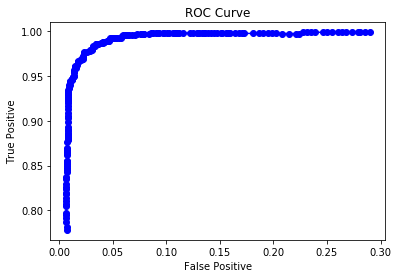

In [6]:
true_p = []
false_p = []

for T in range(-100, 100, 1):
    predictions, accuracy = predict_accuracy(Xval, Yval, T)
    mat = confusion_matrix(Yval, predictions)
    true_p.append((mat[0][0])/(mat[0][0]+mat[1][0]))
    false_p.append((mat[0][1])/(mat[0][1]+mat[1][1]))
plt.title("ROC Curve")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.plot(false_p, true_p, '-bo')

In [7]:
predictions, accuracy = predict_accuracy(Xval, Yval, 0)
print("Validation Accuracy: ",accuracy)

predictions, accuracy = predict_accuracy(Xtt, Ytt, 0)
print("Test Accuracy: ",accuracy)

Validation Accuracy:  0.9756387403446227
Test Accuracy:  0.9691027926322044


AUC: 0.99


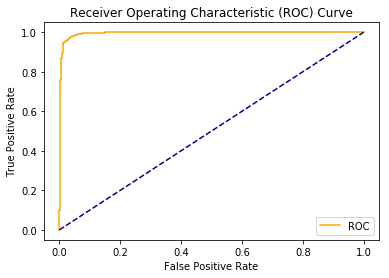

In [8]:
predictions = W.T.dot(Xtt.T) + B
predictions = predictions.flatten()
auc = roc_auc_score(Ytt, predictions)  
print('AUC: %.2f' % auc)  
fpr, tpr, thresholds = roc_curve(Ytt, predictions)  
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()